# NBA Historical View

# Imports

In [35]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA


import psycopg2
from dotenv import load_dotenv

# Constants

In [36]:
dotenv_path = ("/Users/maukanmir/Documents/Machine-Learning/NBA Projects/NBA-History-Analysis/dot.env")
load_dotenv(dotenv_path)

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
TABLE_NAME = "salaries_stats_heights"

In [37]:
conn = psycopg2.connect(
    host=DB_HOST,
    database=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    port=DB_PORT
)

query = f"SELECT * FROM {TABLE_NAME}"
df = pd.read_sql_query(query, conn)
conn.close()

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


# Functions

In [38]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def create_sklearn_pipeline(model, kbest=None):
  steps = [
    ("Scaler", MinMaxScaler()),
    ("PowerTransformer", PowerTransformer()),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)

def scatter_plot_visual(df, interested_columns, y):
  
  plt.figure(figsize=(16,16))
  rows = len(interested_columns)
  dims = (rows+4)//3
  for idx, col in enumerate(interested_columns):
    if col == y:
      continue
    plt.subplot(dims, 3, idx+1)
    sns.scatterplot(df, x=y, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def check_distributions(df, interested_columns, type_visual):
  
  plt.figure(figsize=(16, 16))
  rows = len(interested_columns)
  dims = (rows + 3 )//4
  
  for idx, col in enumerate(interested_columns):
    
    plt.subplot(dims, 4, idx+1)
    sns.histplot(data=df[col], kde=True) if type_visual =="hist" else sns.boxplot(df[col])
    plt.title(f"Distribution of {col}")
    plt.ylabel(col)
    plt.xticks(rotation=45)
  
  plt.tight_layout()
  plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(16, 16))
  rows = len(interested_columns)
  dims = (rows + 3 )//4
  
  for idx, col in enumerate(interested_columns):
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    plt.subplot(dims, 4, idx+1)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  
  plt.tight_layout()
  plt.show()

def pca_analysis(X):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  return pd.DataFrame(metric_tracker)

def dist_plot(df, col):
  salary_skewness = df[col].skew()
  salary_kurtosis = df[col].kurtosis()

  plt.figure(figsize=(10, 6))
  sns.histplot(df[col], kde=True, color='blue')
  plt.title(f'Distribution of {col} with Skewness and Kurtosis')
  plt.xlabel(col)
  plt.ylabel('Frequency')

  plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
  plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

  plt.grid(True)
  plt.show()

def class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(20, 20))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Class Breakdown")
  plt.legend()
  plt.show()

def change_draft_round(df):
  
  for idx, row in df.iterrows():
    draft_status = row["draft-status"]
    if "Undrafted" in draft_status:
      df.at[idx, "round"] = 'N/A'
      df.at[idx, "pick"] = "Undrafted"
      continue
    rnd = draft_status.split(" ")[2]
    pick = draft_status.split(" ")[4]
    df.at[idx, "round"] = rnd
    df.at[idx, "pick"] = pick

  return df
  

# EDA Analysis

In [39]:
check_for_nulls_dupes(df)

The amount of Null Values: pos             0
height          0
weight          0
age             0
nationality     0
college-team    0
draft-status    0
salary          0
Name            0
Team            0
GP              0
MPG             0
PPG             0
FGM             0
FGA             0
FG%             0
3PM             0
3PA             0
3P%             0
FTM             0
FTA             0
FT%             0
ORB             0
DRB             0
RPG             0
APG             0
SPG             0
BPG             0
TOV             0
season          0
dtype: int64
The amount of Duplicated Values 0


In [40]:
df.dtypes

pos              object
height           object
weight            int64
age               int64
nationality      object
college-team     object
draft-status     object
salary          float64
Name             object
Team             object
GP                int64
MPG             float64
PPG             float64
FGM             float64
FGA             float64
FG%             float64
3PM             float64
3PA             float64
3P%             float64
FTM             float64
FTA             float64
FT%             float64
ORB             float64
DRB             float64
RPG             float64
APG             float64
SPG             float64
BPG             float64
TOV             float64
season           object
dtype: object

In [41]:
df.describe()

weight          age        salary           GP          MPG  \
count  7164.000000  7164.000000  7.164000e+03  7164.000000  7164.000000   
mean    220.081100    26.550251  5.868771e+06    70.501396    25.973786   
std      27.332273     3.958512  6.877985e+06     9.991962     7.937144   
min     133.000000    18.000000  5.000000e+04    30.000000     4.900000   
25%     200.000000    24.000000  1.517981e+06    64.000000    19.675000   
50%     220.000000    26.000000  3.200000e+06    73.000000    26.300000   
75%     240.000000    29.000000  7.612749e+06    79.000000    32.600000   
max     310.000000    42.000000  5.191562e+07    85.000000    43.700000   

               PPG          FGM          FGA          FG%          3PM  ...  \
count  7164.000000  7164.000000  7164.000000  7164.000000  7164.000000  ...   
mean     11.215648     4.189489     9.068788     0.461778     0.773479  ...   
std       5.982018     2.161540     4.547569     0.056143     0.797294  ...   
min       0.800000     0.300000     0.600000     0.282000     0.000000  ...   
25%       6.600000     2.500000     5.500000     0.425000     0.000000  ...   
50%      10.100000     3.800000     8.300000     0.454000     0.600000  ...   
75%      14.700000     5.500000    11.900000     0.491000     1.300000  ...   
max      36.100000    12.700000    27.800000     0.763000     5.300000  ...   

               FTM          FTA          FT%          ORB          DRB  \
count  7164.000000  7164.000000  7164.000000  7164.000000  7164.000000   
mean      2.062605     2.700140     0.752582     1.233124     3.395980   
std       1.536209     1.907387     0.101324     0.904331     1.840044   
min       0.000000     0.000000     0.111000     0.100000     0.300000   
25%       1.000000     1.300000     0.700000     0.500000     2.100000   
50%       1.600000     2.200000     0.769000     1.000000     3.000000   
75%       2.700000     3.600000     0.824000     1.700000     4.300000   
max      10.200000    12.300000     1.000000     6.800000    12.300000   

               RPG          APG          SPG          BPG          TOV  
count  7164.000000  7164.000000  7164.000000  7164.000000  7164.000000  
mean      4.627178     2.514419     0.842406     0.536488     1.512549  
std       2.581510     2.038083     0.446776     0.548810     0.792857  
min       0.400000     0.000000     0.000000     0.000000     0.100000  
25%       2.700000     1.000000     0.500000     0.200000     0.900000  
50%       4.000000     1.900000     0.800000     0.400000     1.400000  
75%       5.900000     3.400000     1.100000     0.700000     2.000000  
max      18.700000    14.200000     3.000000     4.500000     5.700000  

[8 rows x 22 columns]

In [42]:
df["height"] = df["height"].apply(lambda x: float(x.replace("-", ".")))

In [43]:
df

pos  height  weight  age           nationality    college-team  \
0     SG     6.6     215   27         United States  North Carolina   
1     PF     6.9     265   26         United States  Louisiana Tech   
2     SF     6.7     205   33         United States       Tennessee   
3     PF     6.6     252   27         United States          Auburn   
4      C     7.0     240   27  United StatesJamaica      Georgetown   
...   ..     ...     ...  ...                   ...             ...   
7159  PF     6.7     210   24                Canada        Syracuse   
7160   G     6.0     185   26         United States             USC   
7161  PF     6.1     240   31                Canada        Stanford   
7162  PF     6.9     240   22         United States         Arizona   
7163  PG     6.7     195   20         United States         Arizona   

                   draft-status     salary               Name Team  ...   FTA  \
0             1984 Rnd 1 Pick 3  2500000.0     Michael Jordan  CHI  ...   8.2   
1            1985 Rnd 1 Pick 13  2260000.0        Karl Malone  UTA  ...  10.8   
2             1977 Rnd 1 Pick 7  1600000.0       Bernard King  WAS  ...   7.6   
3             1984 Rnd 1 Pick 5  2900000.0    Charles Barkley  PHI  ...   9.8   
4             1985 Rnd 1 Pick 1  4250000.0      Patrick Ewing  NYK  ...   7.7   
...                         ...        ...                ...  ...  ...   ...   
7159  2019 NBA Draft, Undrafted  2165000.0     Oshae Brissett  BOS  ...   1.5   
7160  2018 NBA Draft, Undrafted  2420000.0  Jordan McLaughlin  MIN  ...   0.3   
7161         2014 Rnd 2 Pick 15  4000000.0      Dwight Powell  DAL  ...   1.4   
7162         2020 Rnd 1 Pick 22  4306281.0         Zeke Nnaji  DEN  ...   1.1   
7163         2022 Rnd 1 Pick 18  3350760.0        Dalen Terry  CHI  ...   0.7   

        FT%  ORB  DRB   RPG  APG  SPG  BPG  TOV     season  
0     0.851  1.4  4.6   6.0  5.5  2.7  1.0  2.5  1990-1991  
1     0.770  2.9  8.9  11.8  3.3  1.1  1.0  3.0  1990-1991  
2     0.790  1.8  3.2   5.0  4.6  0.9  0.3  4.0  1990-1991  
3     0.722  3.9  6.3  10.1  4.2  1.6  0.5  3.1  1990-1991  
4     0.745  2.4  8.8  11.2  3.0  1.0  3.2  3.6  1990-1991  
...     ...  ...  ...   ...  ...  ...  ...  ...        ...  
7159  0.602  1.1  1.8   2.9  0.8  0.3  0.1  0.4  2023-2024  
7160  0.722  0.3  1.0   1.3  2.0  0.6  0.1  0.3  2023-2024  
7161  0.708  1.5  1.9   3.4  1.3  0.4  0.3  0.5  2023-2024  
7162  0.677  1.1  1.1   2.2  0.6  0.3  0.7  0.5  2023-2024  
7163  0.581  0.5  1.4   1.9  1.4  0.5  0.3  0.5  2023-2024  

[7164 rows x 30 columns]

In [44]:
df = change_draft_round(df)

In [45]:
numeric_cols = df.select_dtypes(include=["float64", "int64"])

In [46]:
df

pos  height  weight  age           nationality    college-team  \
0     SG     6.6     215   27         United States  North Carolina   
1     PF     6.9     265   26         United States  Louisiana Tech   
2     SF     6.7     205   33         United States       Tennessee   
3     PF     6.6     252   27         United States          Auburn   
4      C     7.0     240   27  United StatesJamaica      Georgetown   
...   ..     ...     ...  ...                   ...             ...   
7159  PF     6.7     210   24                Canada        Syracuse   
7160   G     6.0     185   26         United States             USC   
7161  PF     6.1     240   31                Canada        Stanford   
7162  PF     6.9     240   22         United States         Arizona   
7163  PG     6.7     195   20         United States         Arizona   

                   draft-status     salary               Name Team  ...  ORB  \
0             1984 Rnd 1 Pick 3  2500000.0     Michael Jordan  CHI  ...  1.4   
1            1985 Rnd 1 Pick 13  2260000.0        Karl Malone  UTA  ...  2.9   
2             1977 Rnd 1 Pick 7  1600000.0       Bernard King  WAS  ...  1.8   
3             1984 Rnd 1 Pick 5  2900000.0    Charles Barkley  PHI  ...  3.9   
4             1985 Rnd 1 Pick 1  4250000.0      Patrick Ewing  NYK  ...  2.4   
...                         ...        ...                ...  ...  ...  ...   
7159  2019 NBA Draft, Undrafted  2165000.0     Oshae Brissett  BOS  ...  1.1   
7160  2018 NBA Draft, Undrafted  2420000.0  Jordan McLaughlin  MIN  ...  0.3   
7161         2014 Rnd 2 Pick 15  4000000.0      Dwight Powell  DAL  ...  1.5   
7162         2020 Rnd 1 Pick 22  4306281.0         Zeke Nnaji  DEN  ...  1.1   
7163         2022 Rnd 1 Pick 18  3350760.0        Dalen Terry  CHI  ...  0.5   

      DRB   RPG  APG  SPG  BPG  TOV     season  round       pick  
0     4.6   6.0  5.5  2.7  1.0  2.5  1990-1991      1          3  
1     8.9  11.8  3.3  1.1  1.0  3.0  1990-1991      1         13  
2     3.2   5.0  4.6  0.9  0.3  4.0  1990-1991      1          7  
3     6.3  10.1  4.2  1.6  0.5  3.1  1990-1991      1          5  
4     8.8  11.2  3.0  1.0  3.2  3.6  1990-1991      1          1  
...   ...   ...  ...  ...  ...  ...        ...    ...        ...  
7159  1.8   2.9  0.8  0.3  0.1  0.4  2023-2024    N/A  Undrafted  
7160  1.0   1.3  2.0  0.6  0.1  0.3  2023-2024    N/A  Undrafted  
7161  1.9   3.4  1.3  0.4  0.3  0.5  2023-2024      2         15  
7162  1.1   2.2  0.6  0.3  0.7  0.5  2023-2024      1         22  
7163  1.4   1.9  1.4  0.5  0.3  0.5  2023-2024      1         18  

[7164 rows x 32 columns]

<AxesSubplot:>

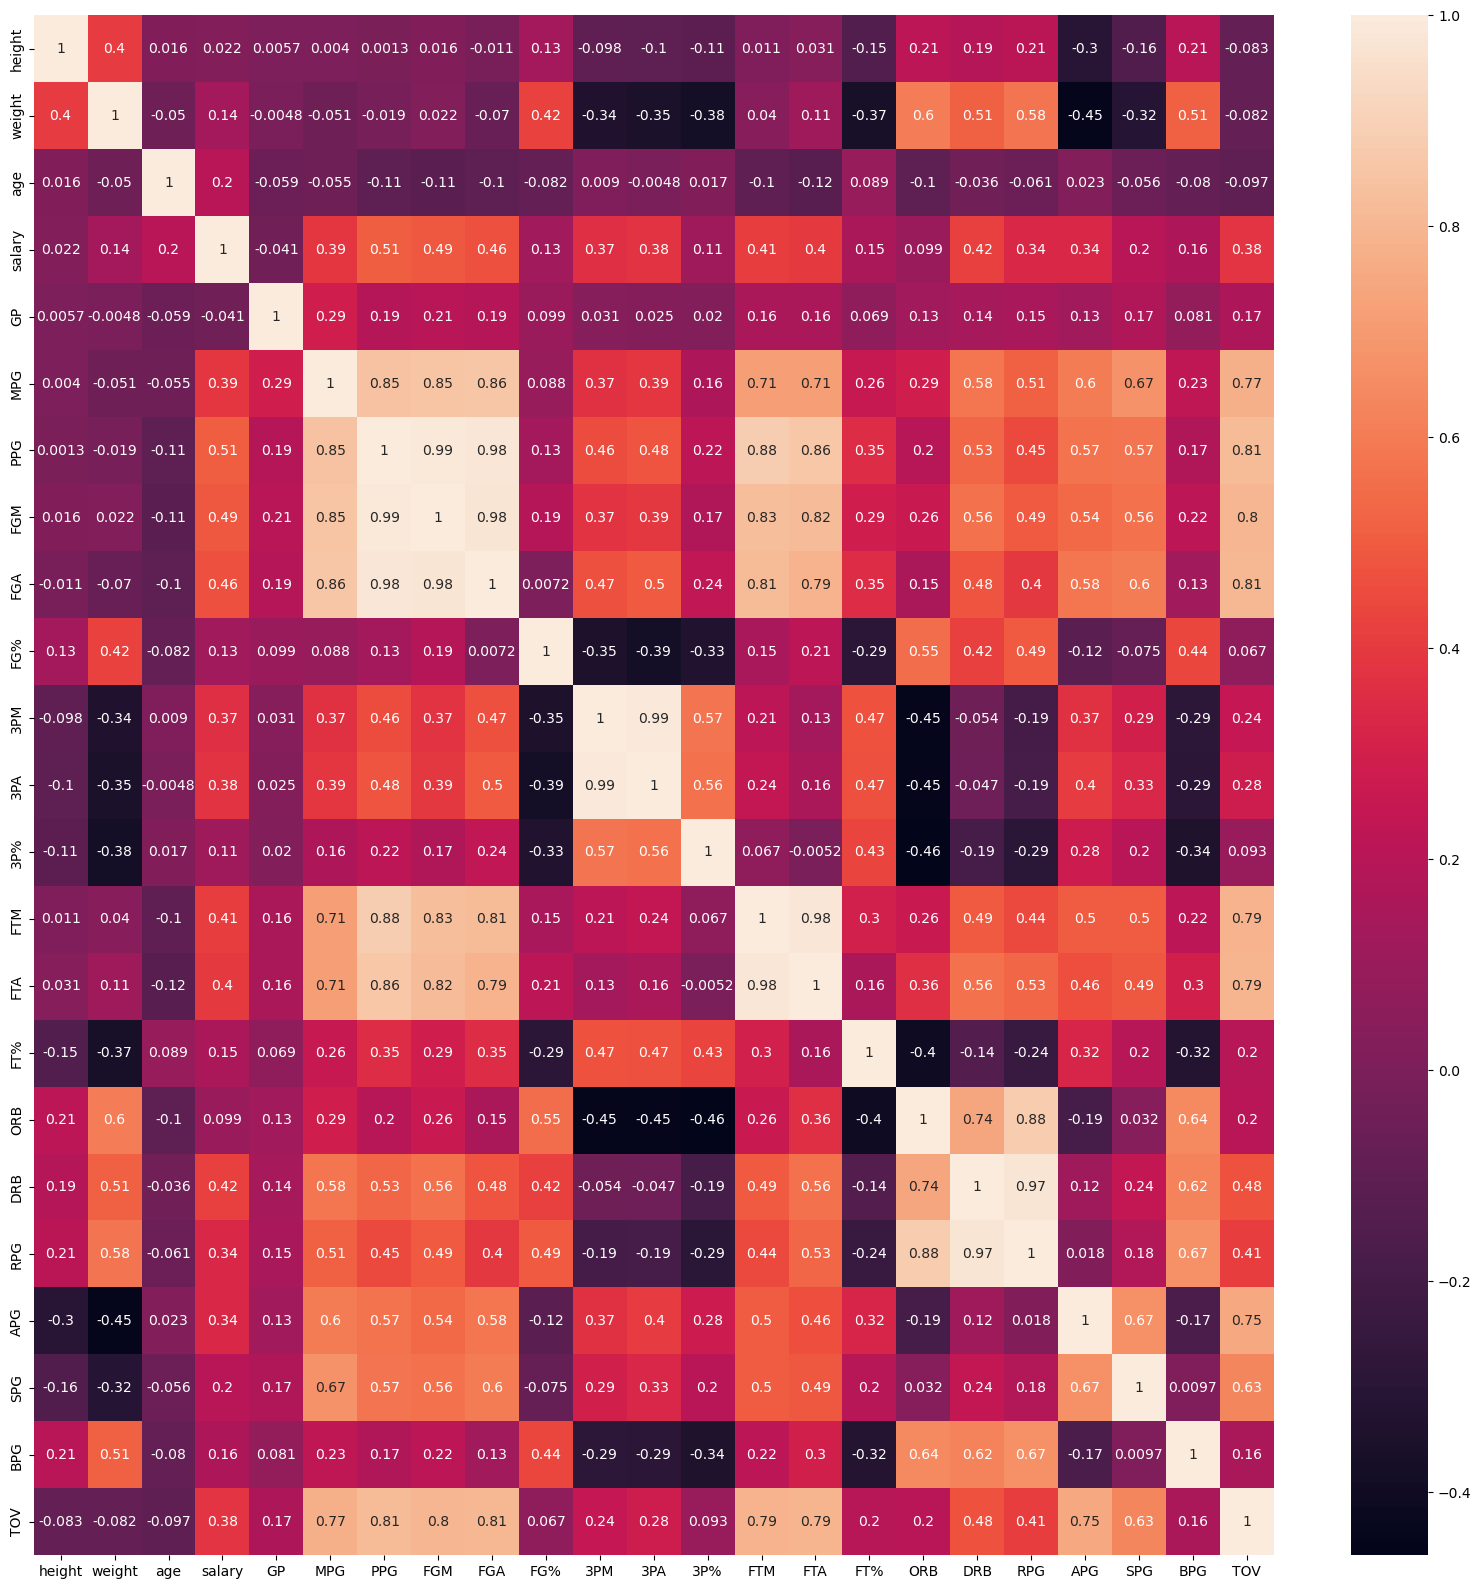

In [47]:
relations = numeric_cols.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(data=relations, annot=True)

In [48]:
interested_columns = [col for col in numeric_cols.columns if col != "salary"]
scatter_plot_visual(numeric_cols, interested_columns, "salary")

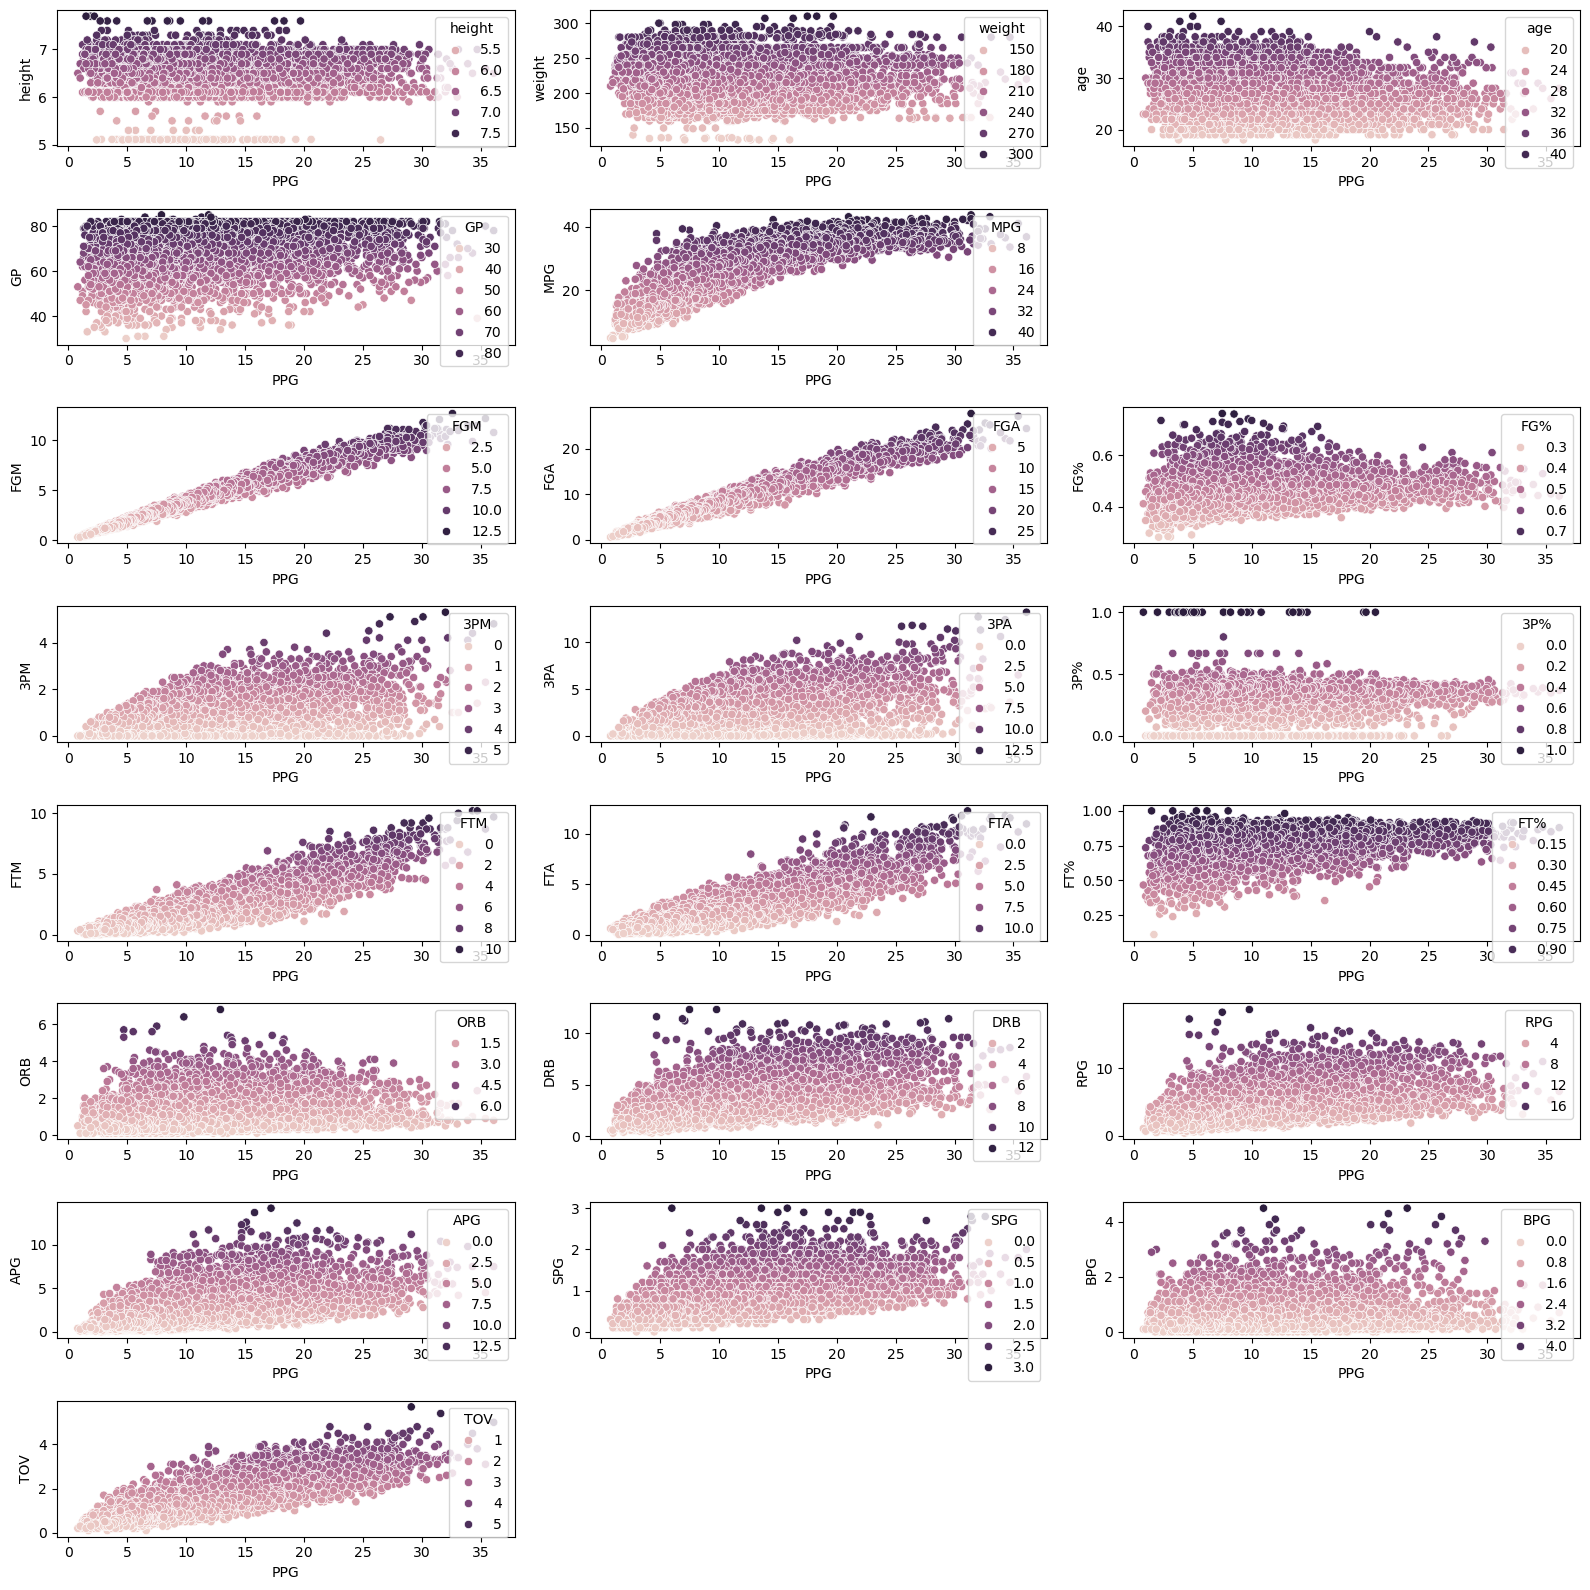

In [ ]:
scatter_plot_visual(numeric_cols, interested_columns, "PPG")

# Check Distributions

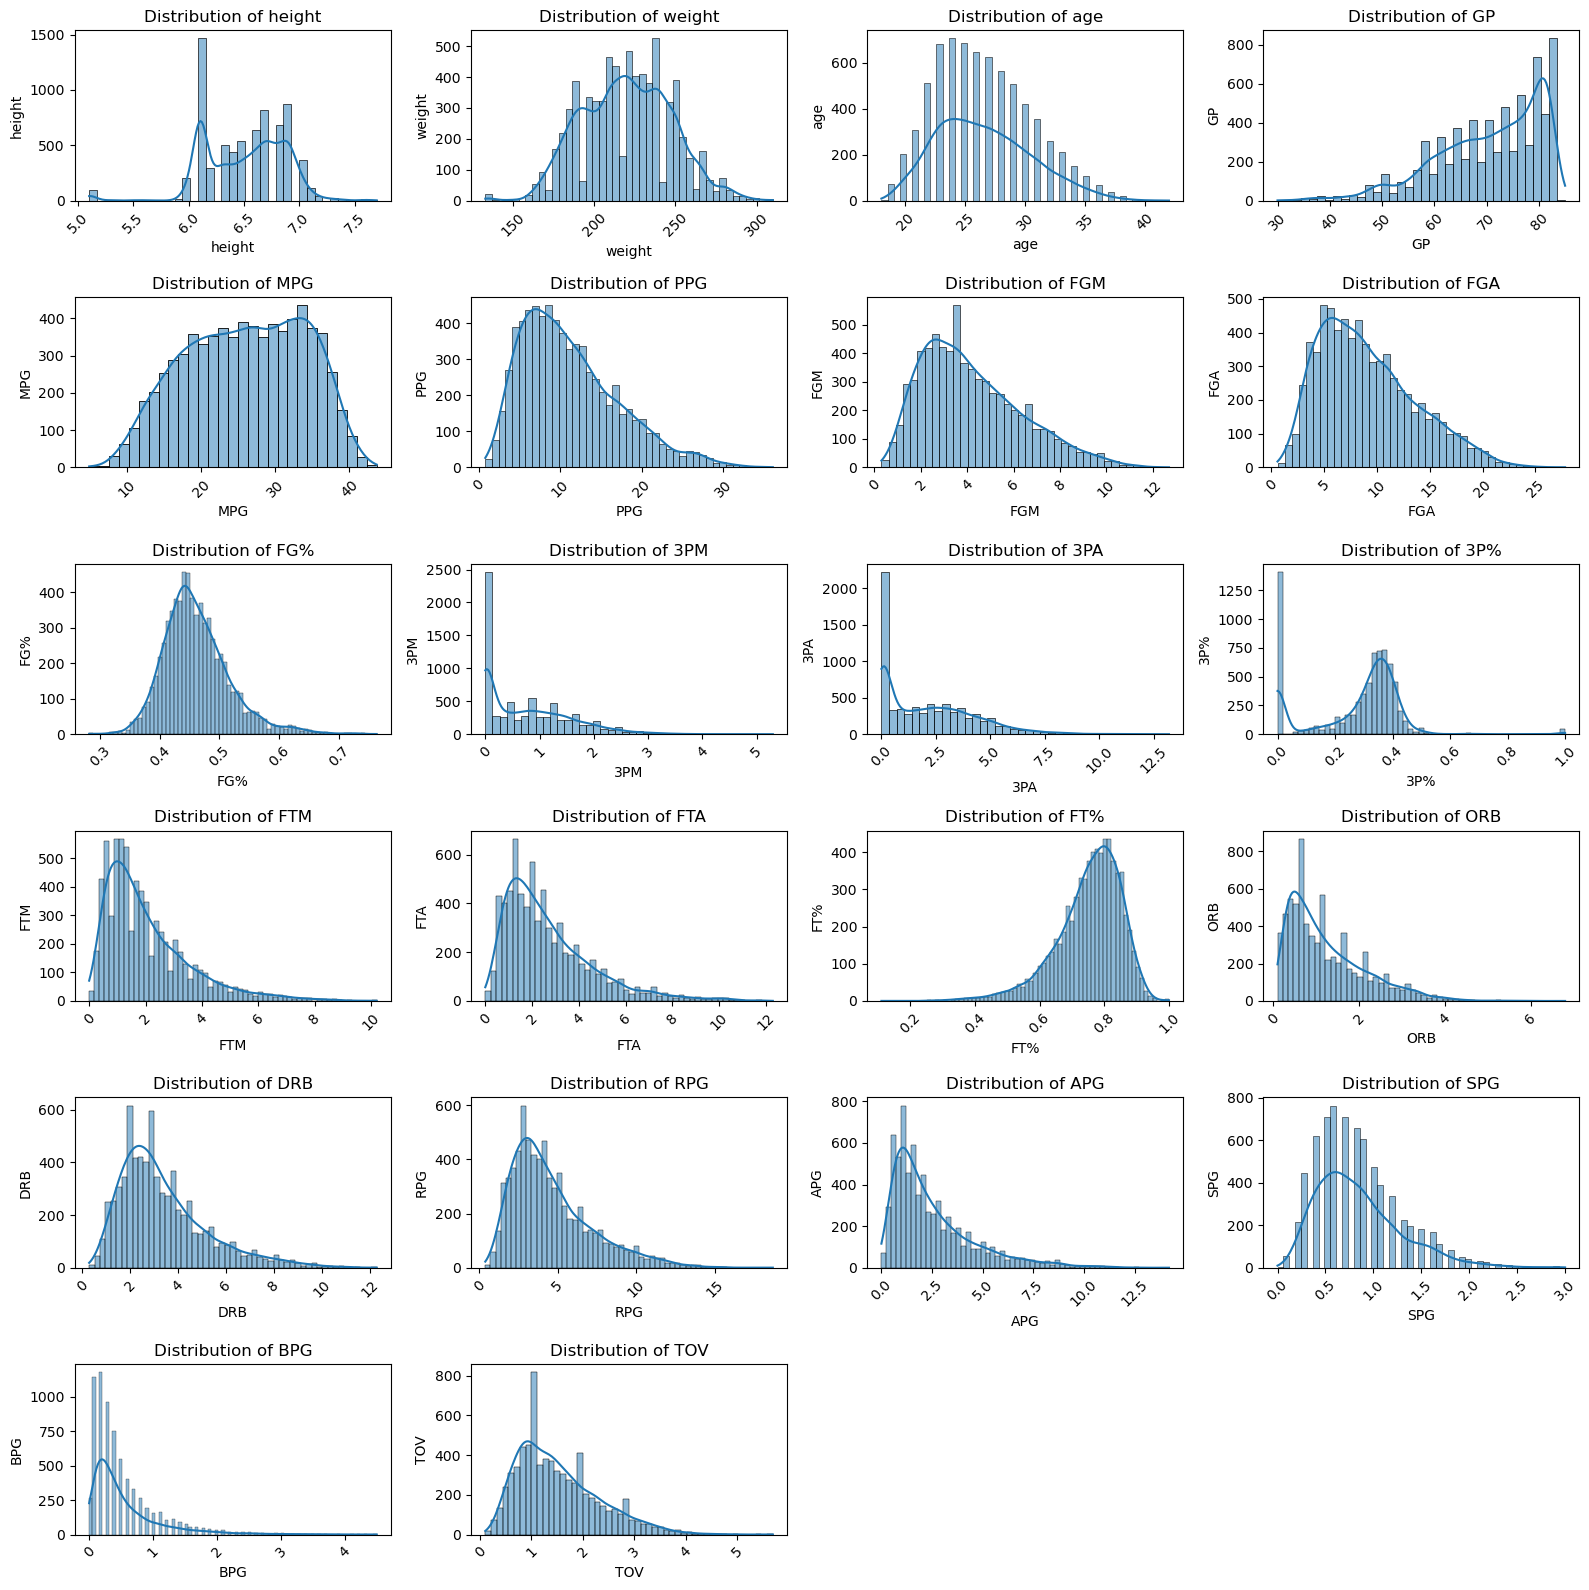

In [ ]:
check_distributions(numeric_cols, interested_columns, "hist")

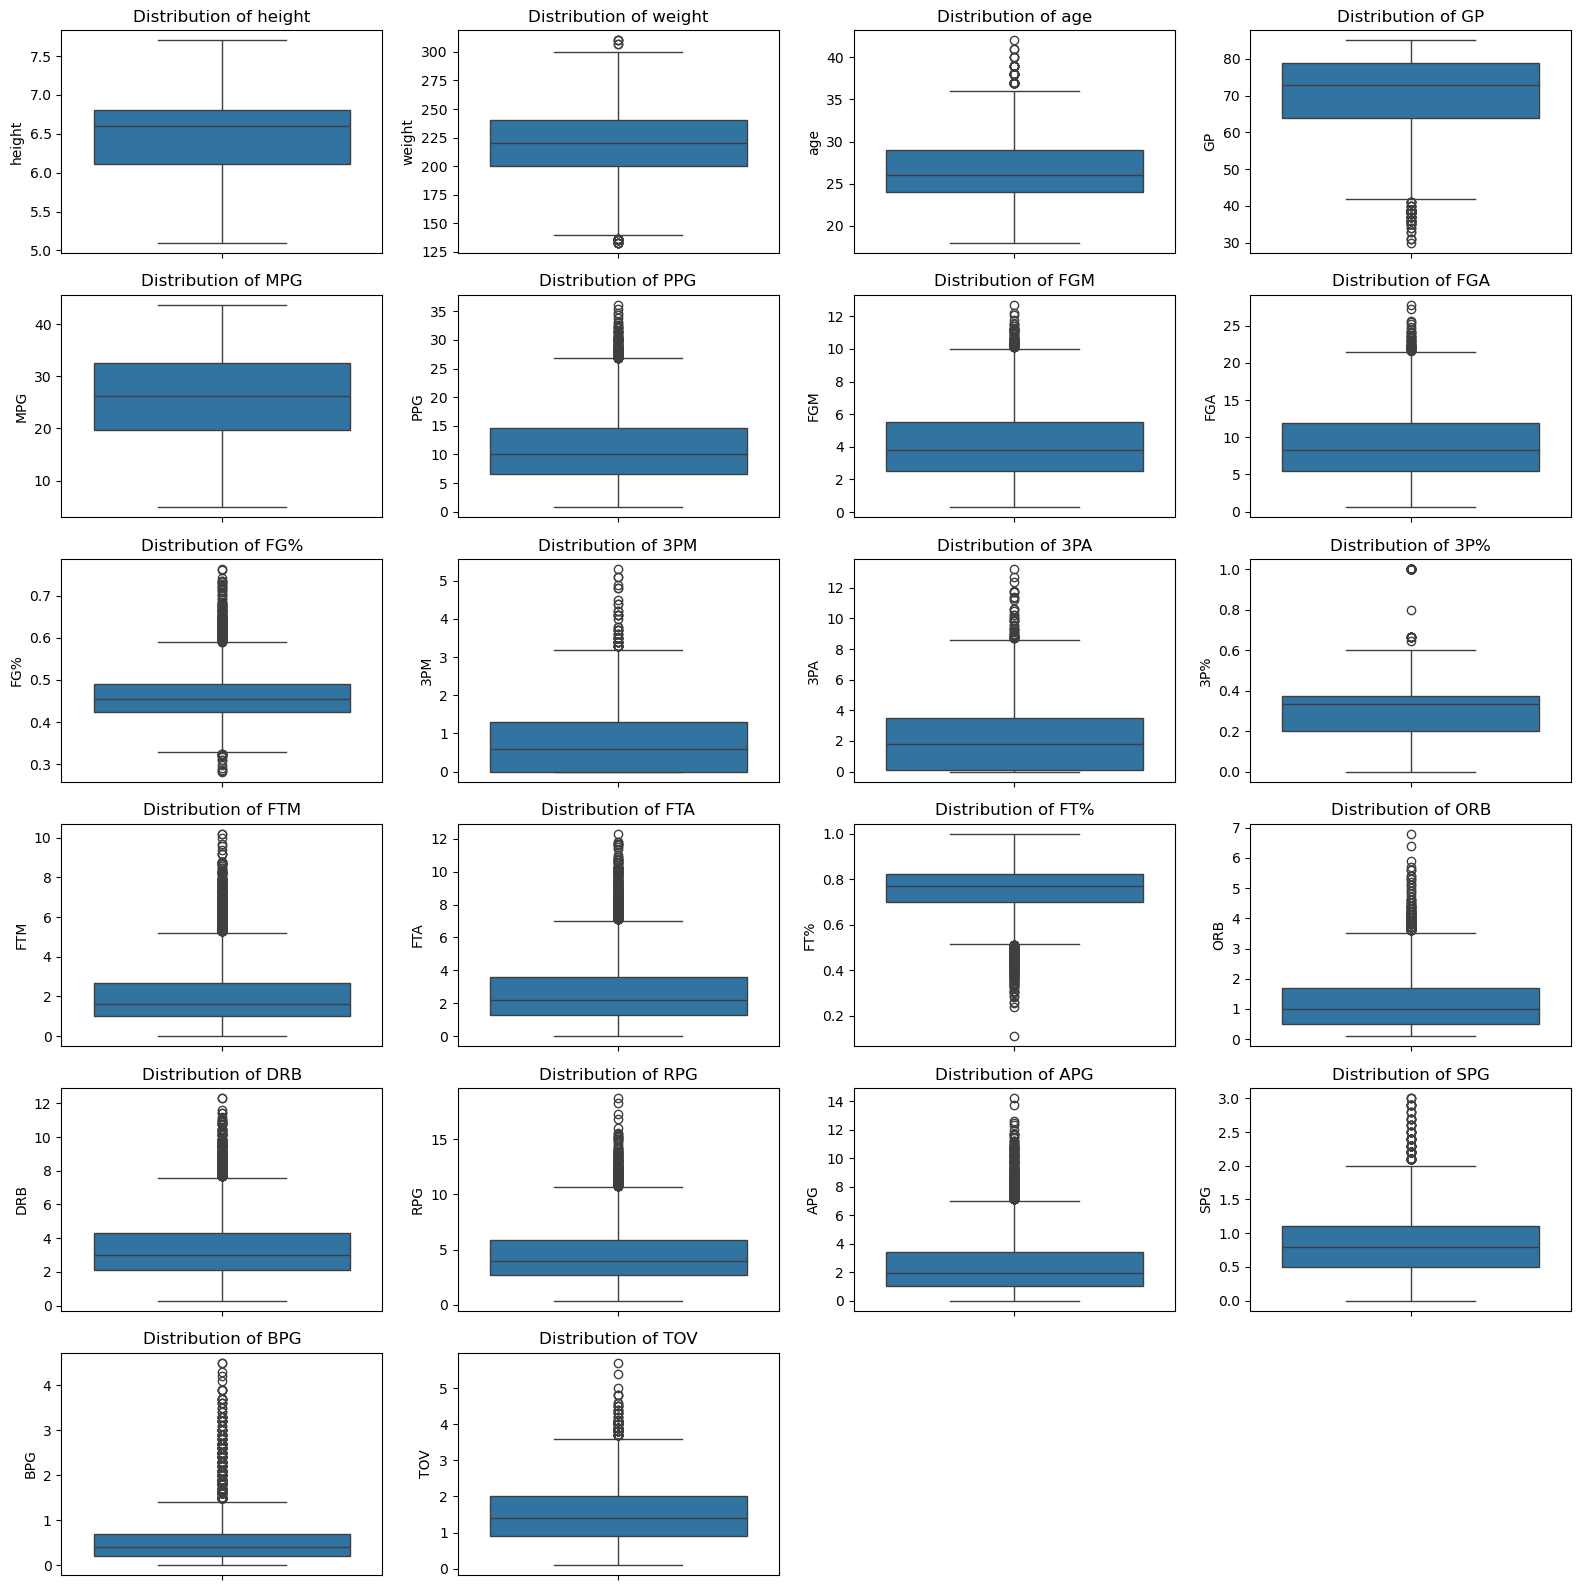

In [ ]:
check_distributions(numeric_cols, interested_columns, "boxplot")

# Aggregate Views

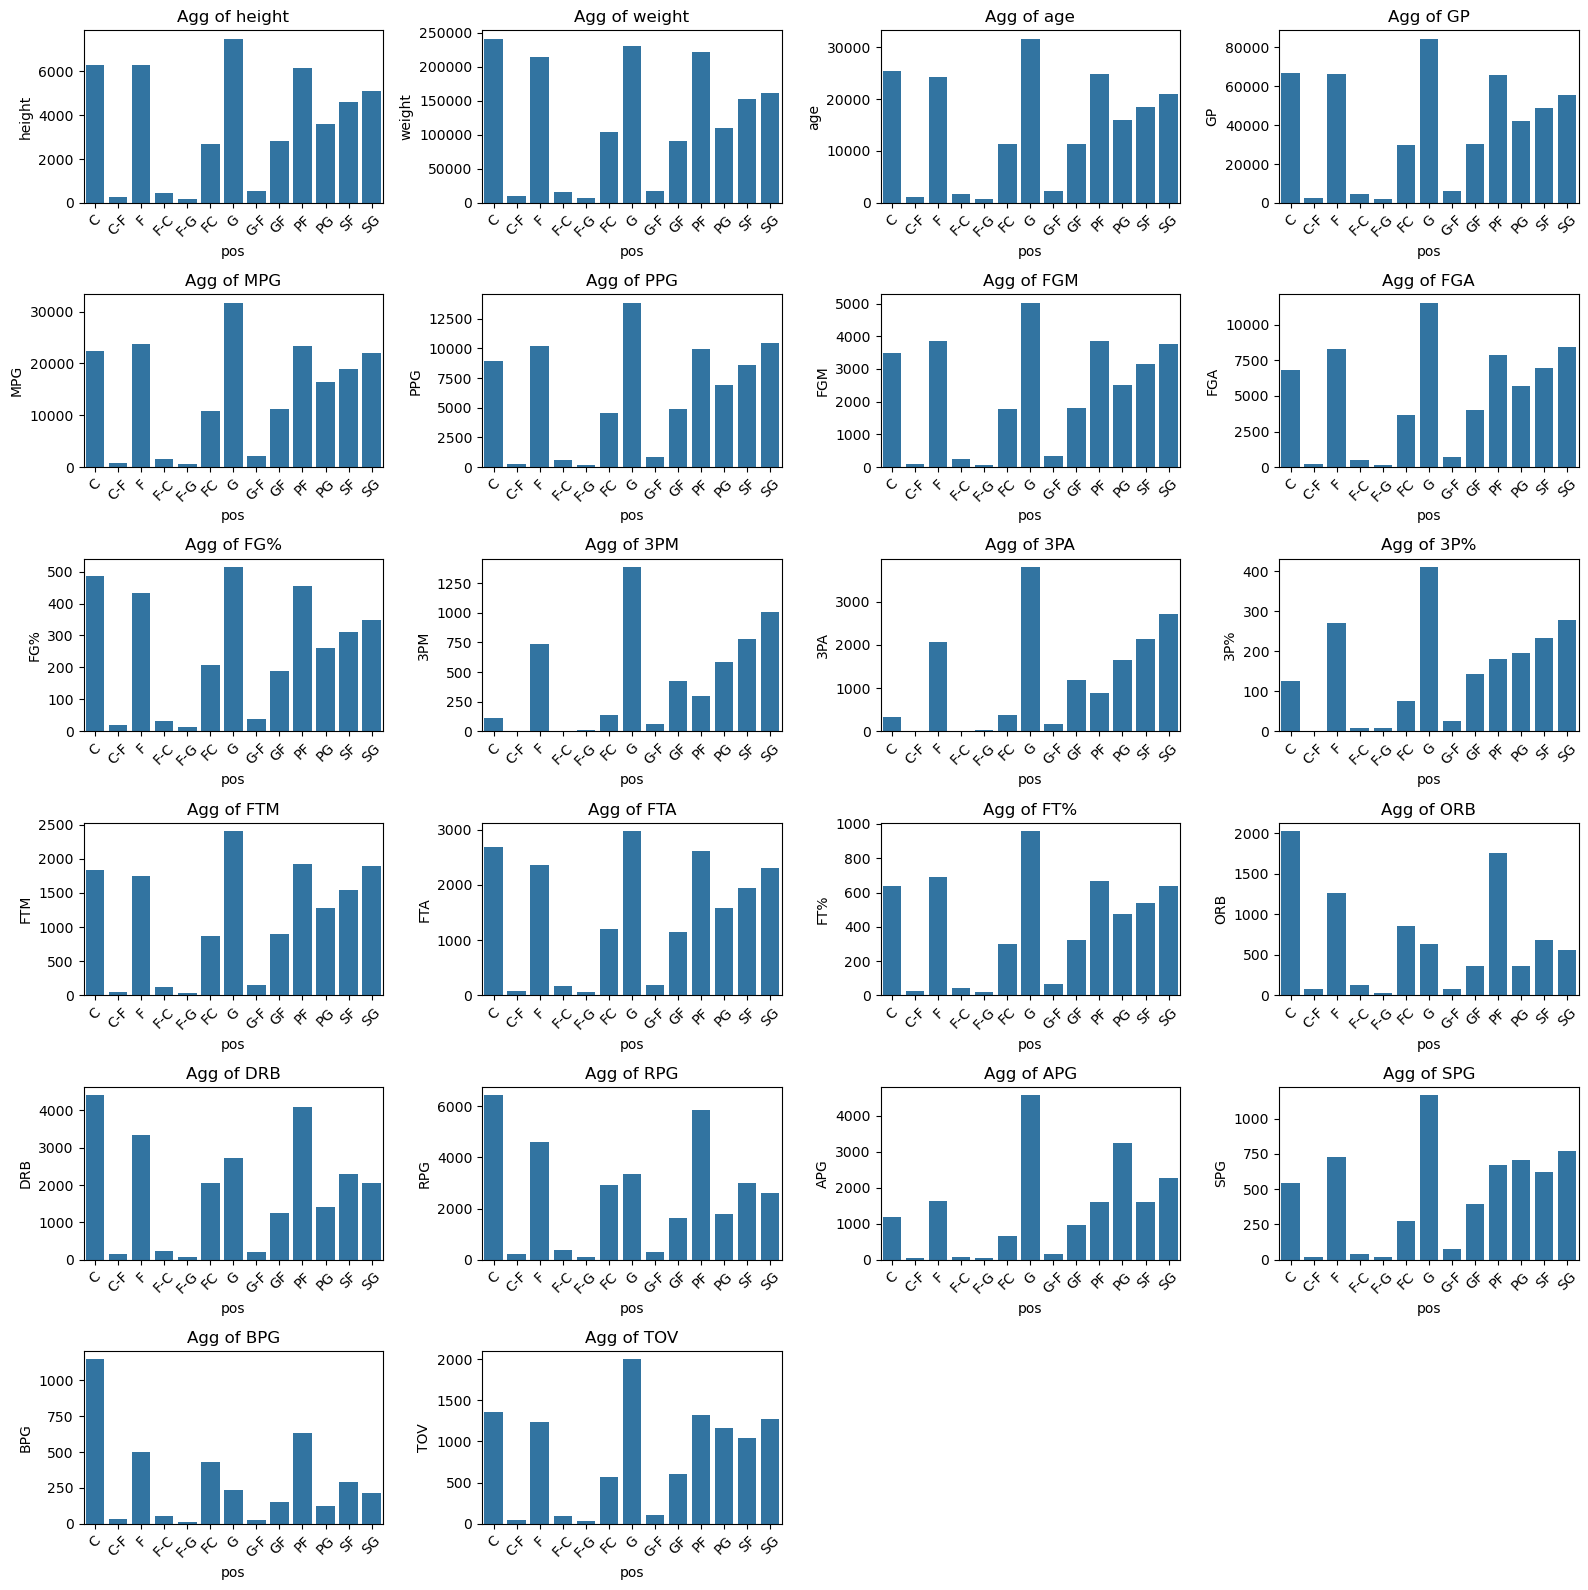

In [ ]:
aggregate_dataset(df, interested_columns, "pos", "sum")

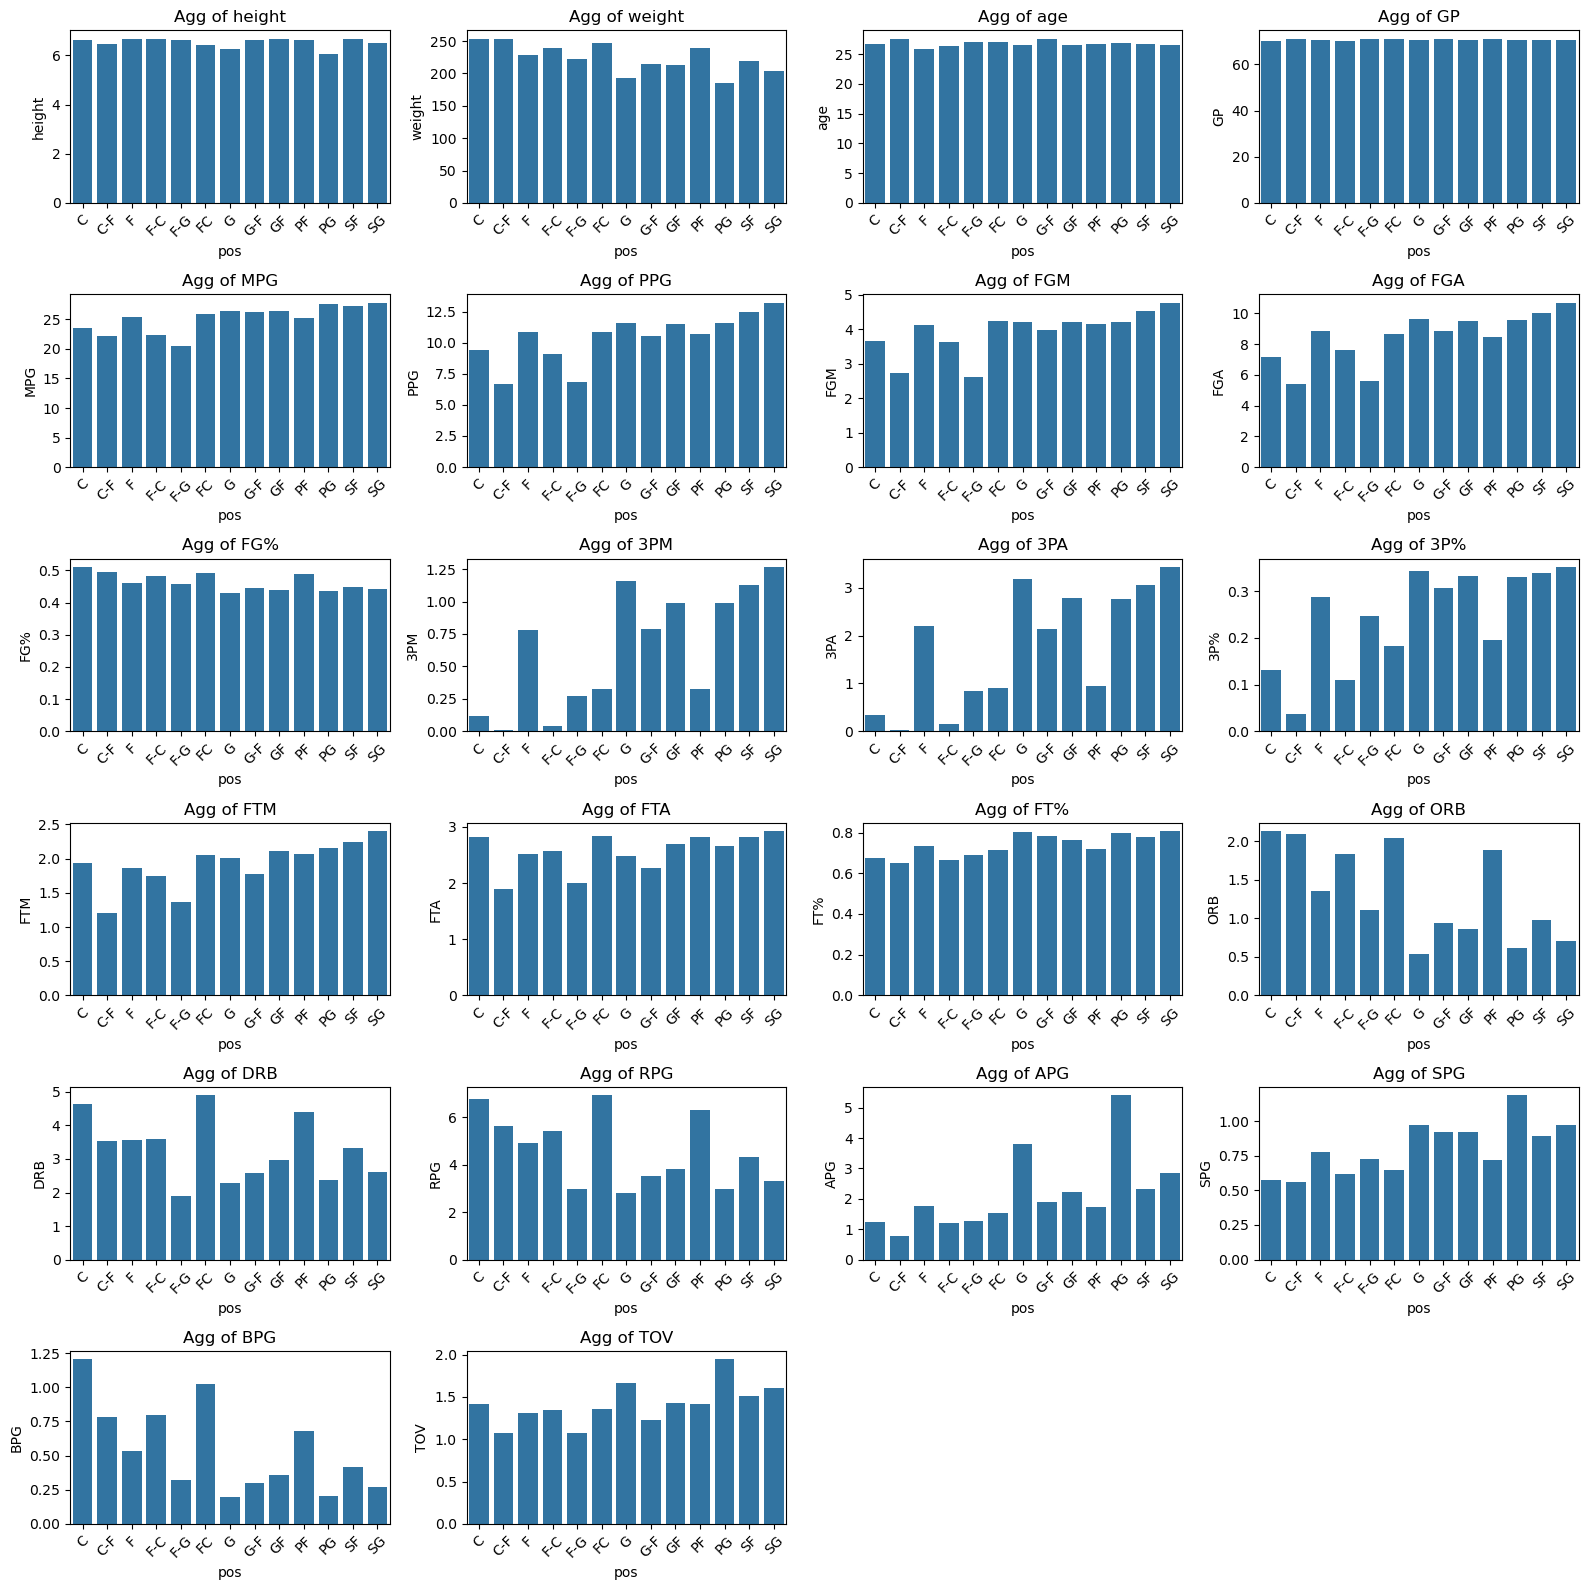

In [ ]:
aggregate_dataset(df, interested_columns, "pos", "mean")

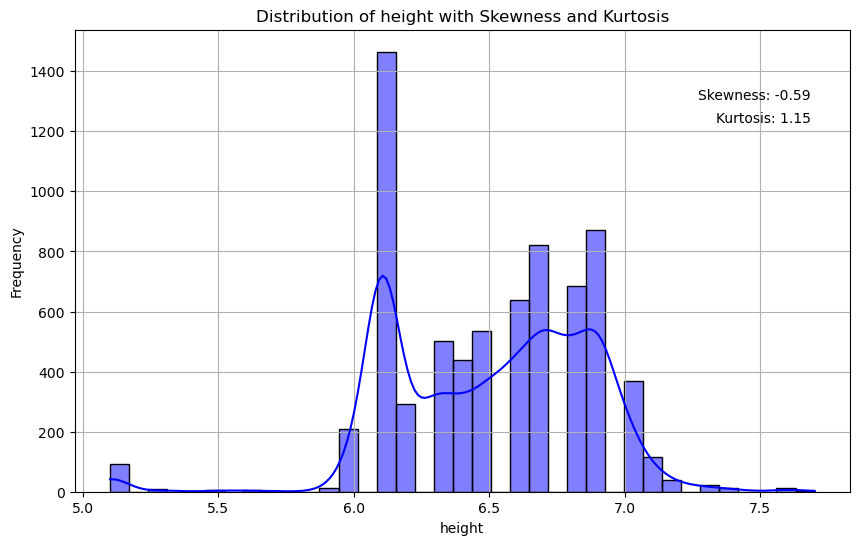

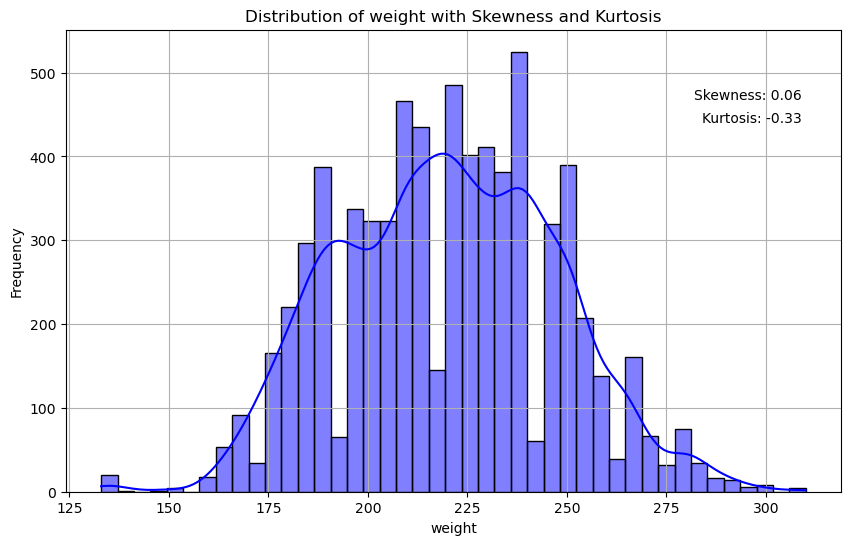

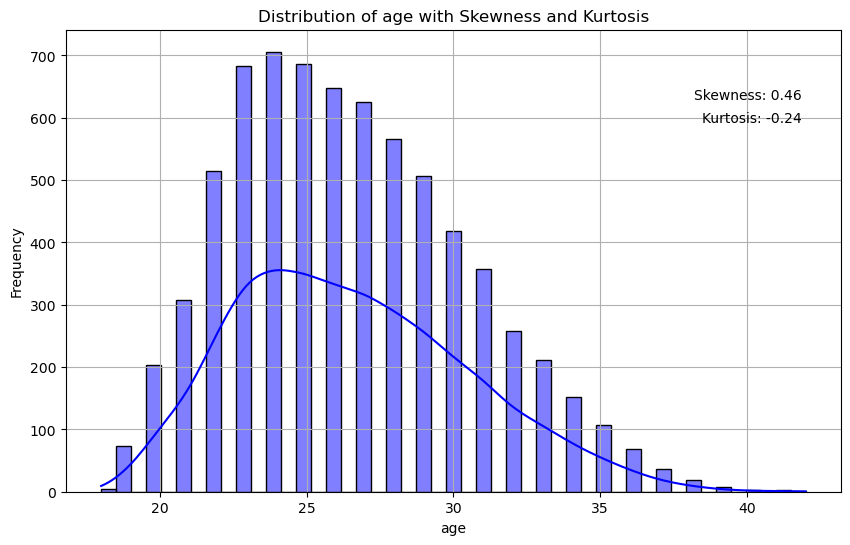

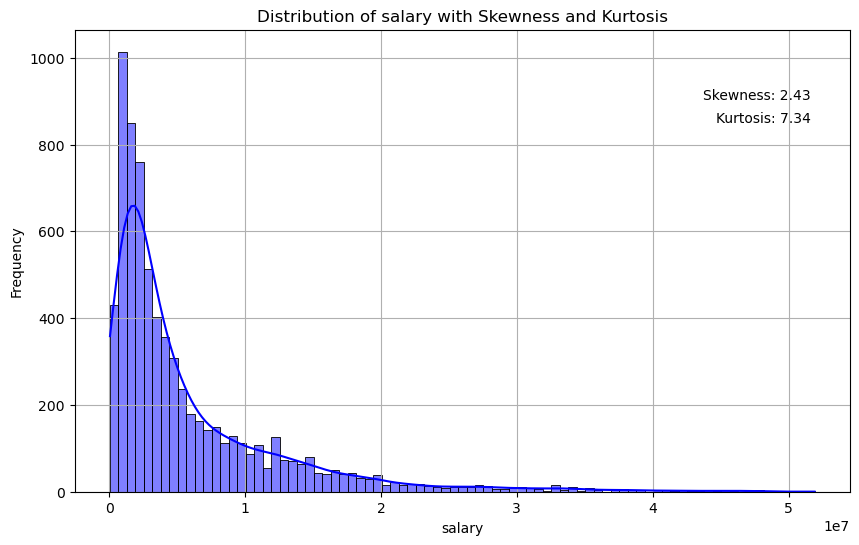

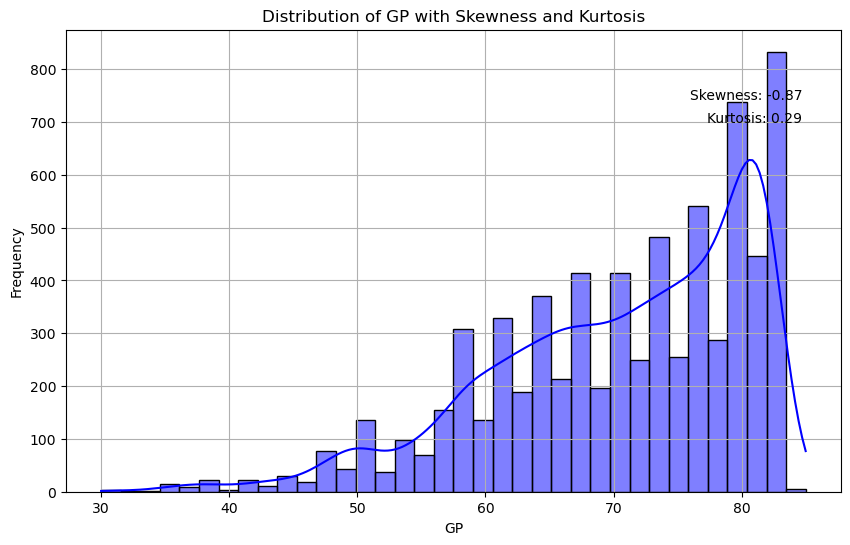

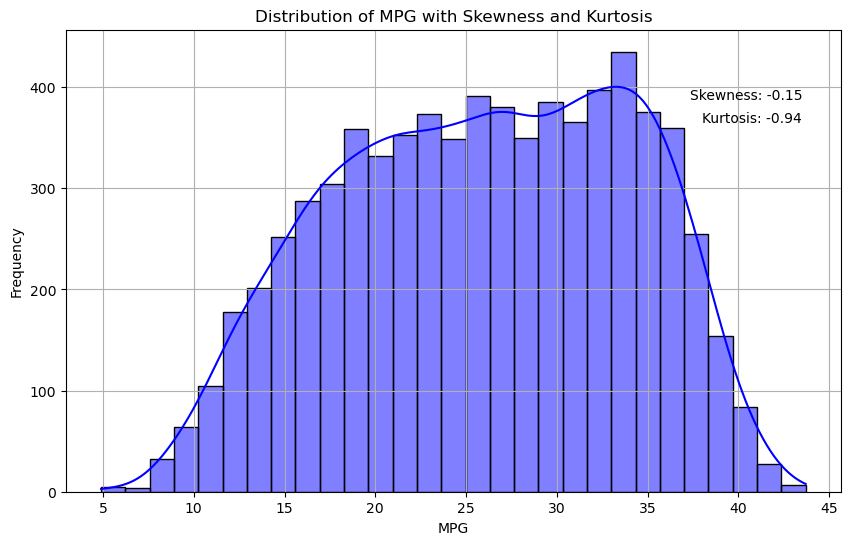

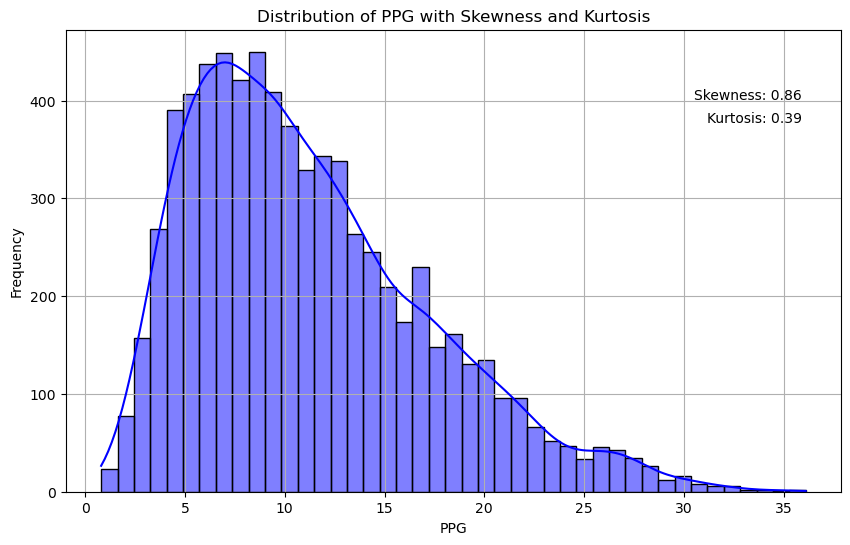

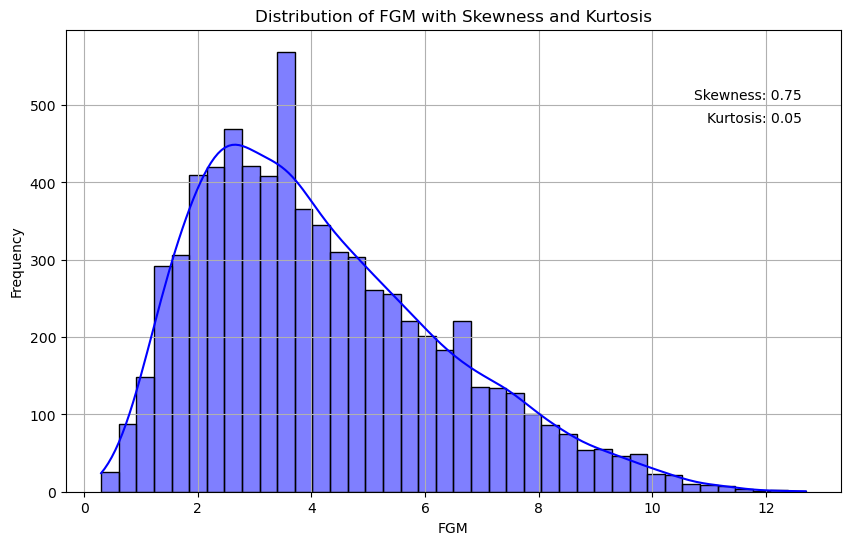

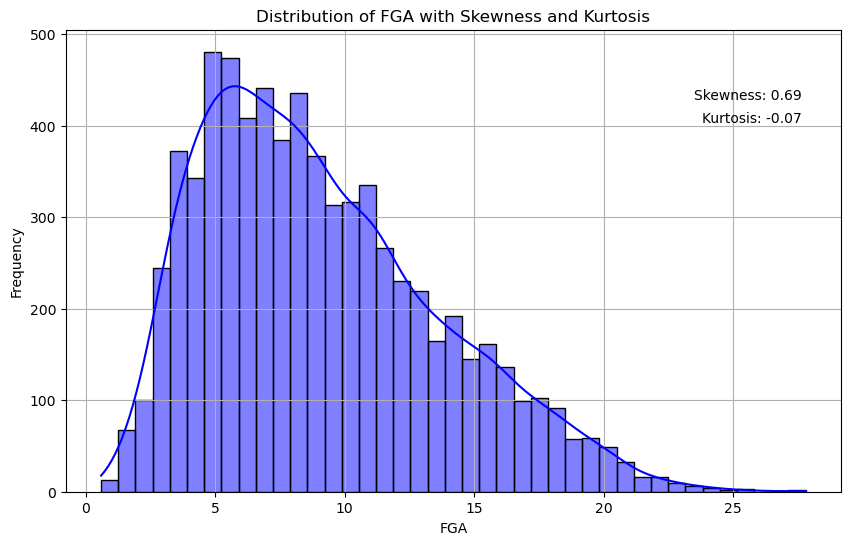

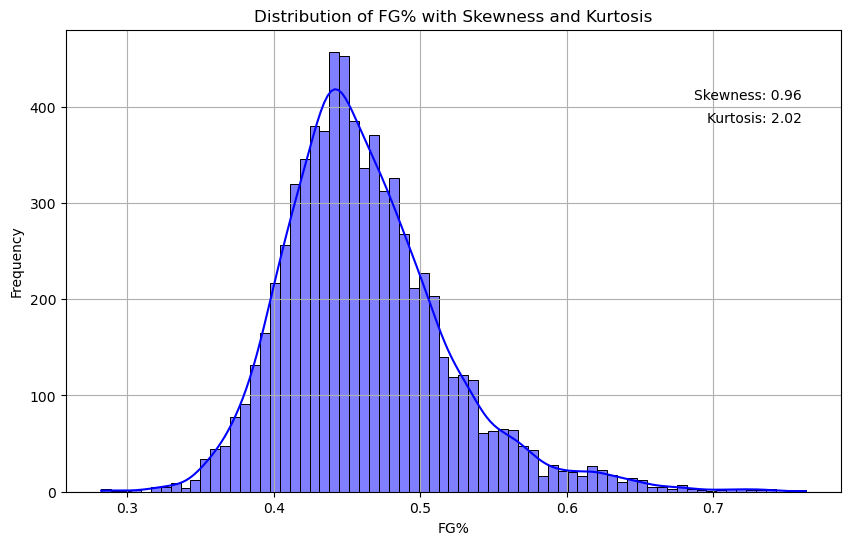

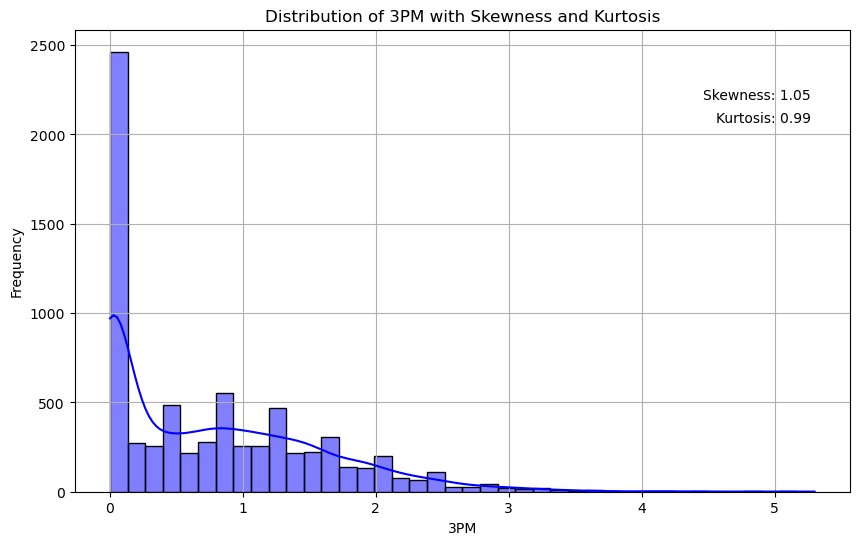

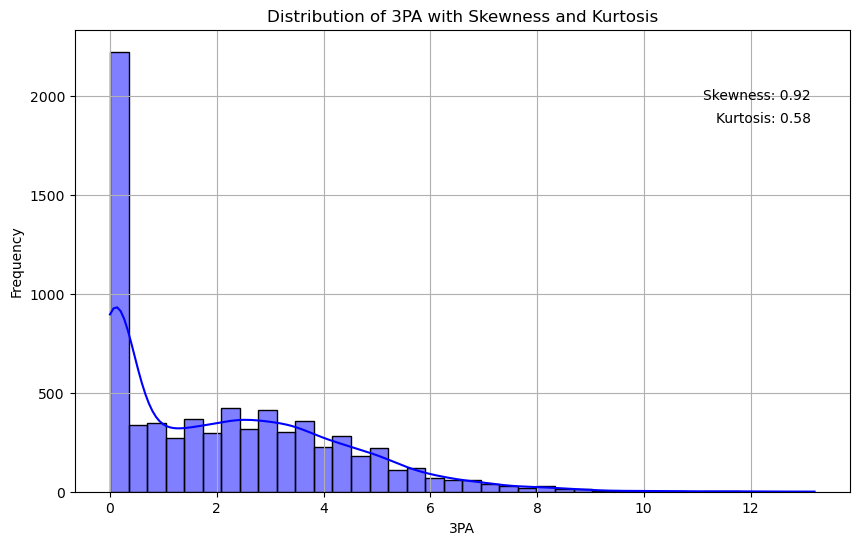

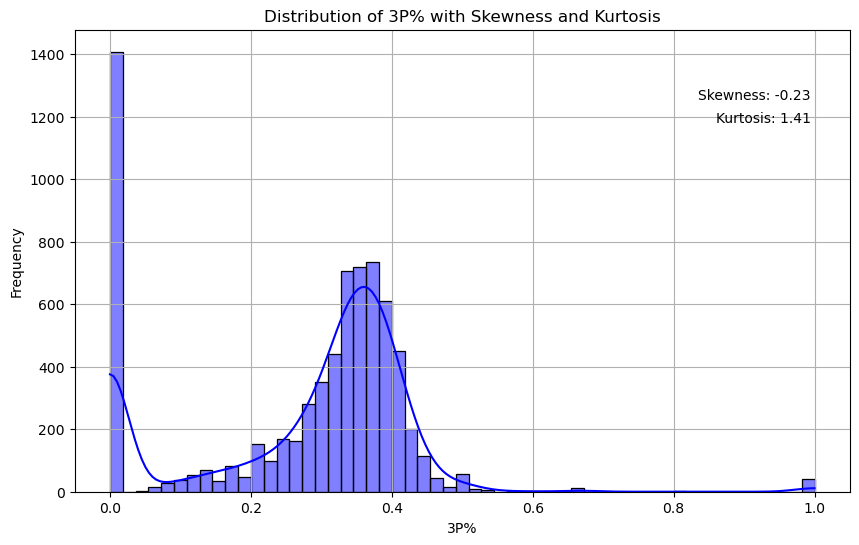

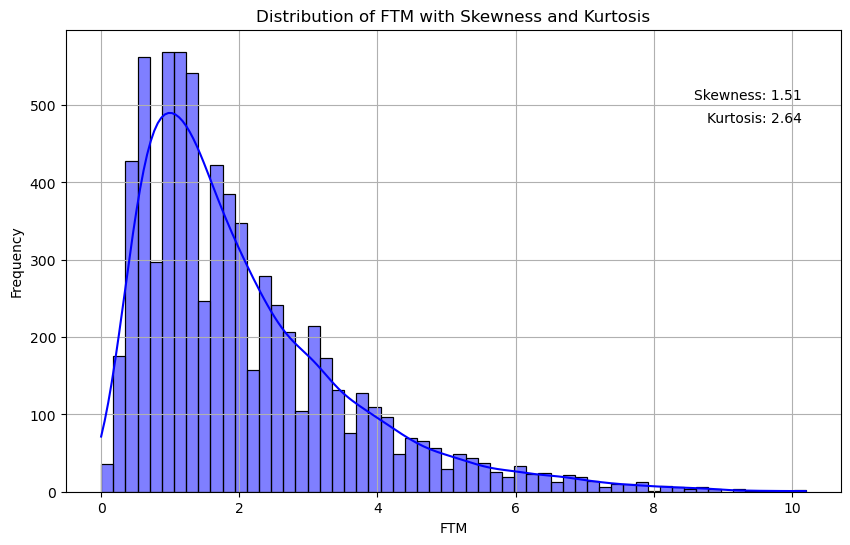

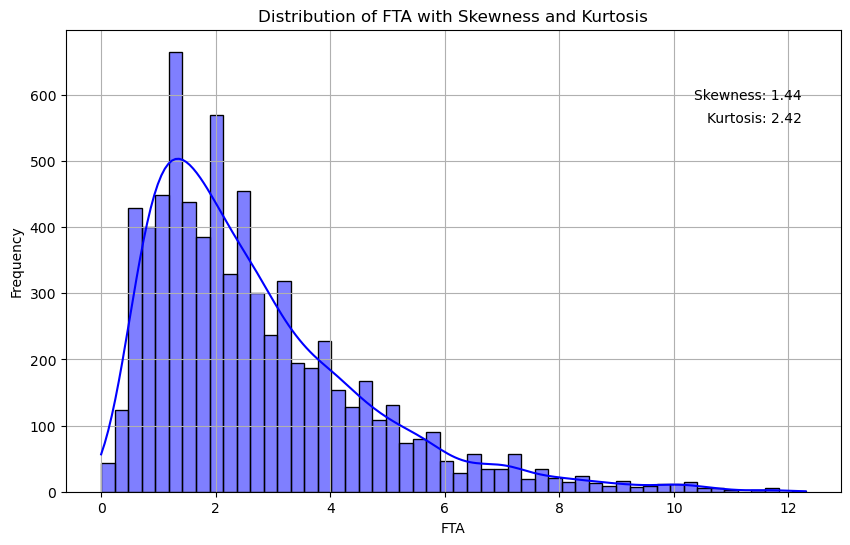

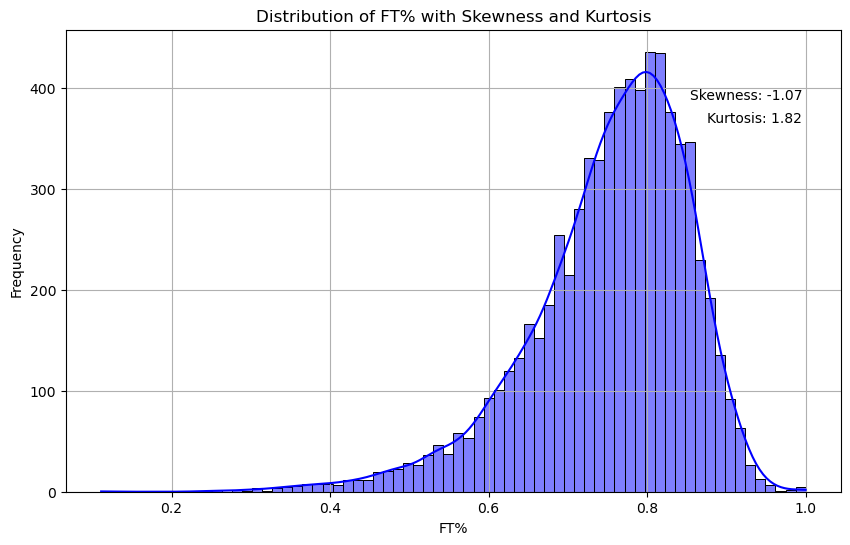

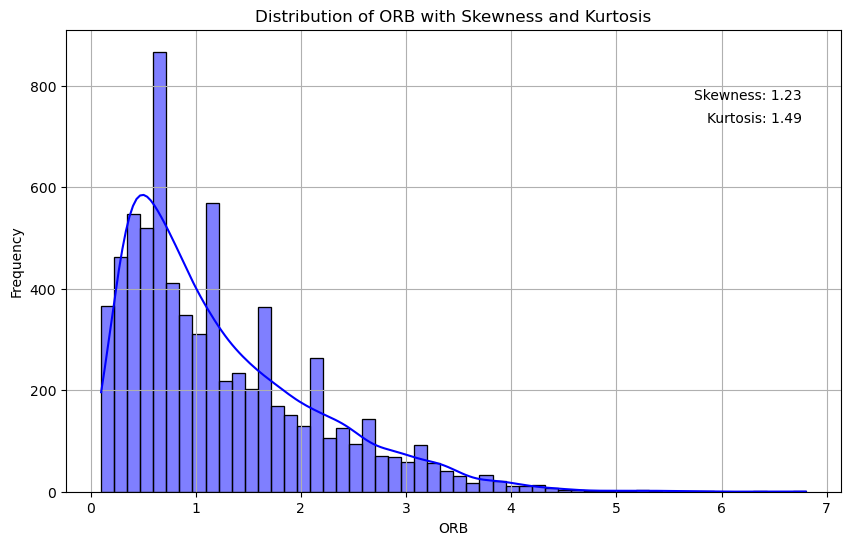

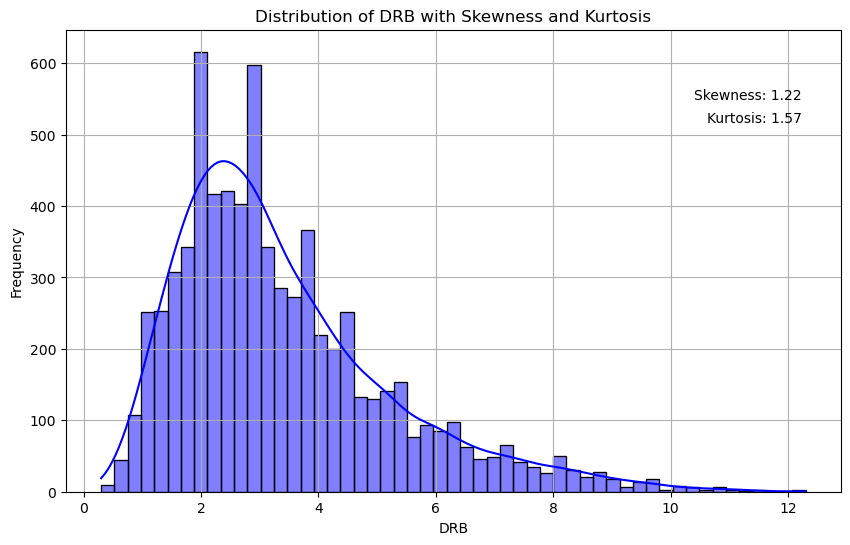

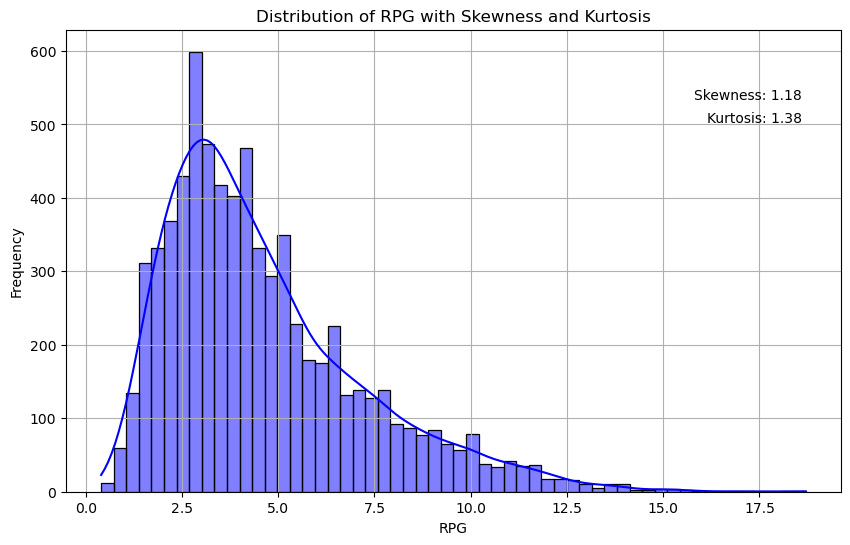

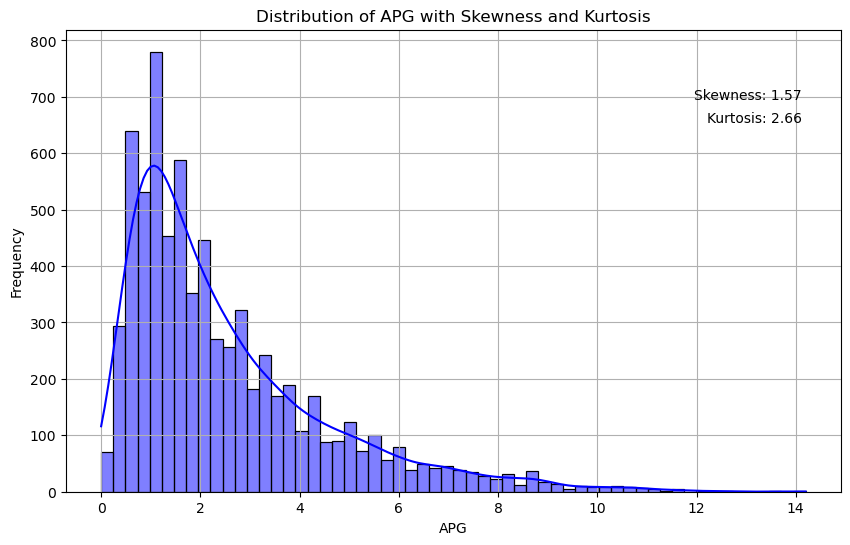

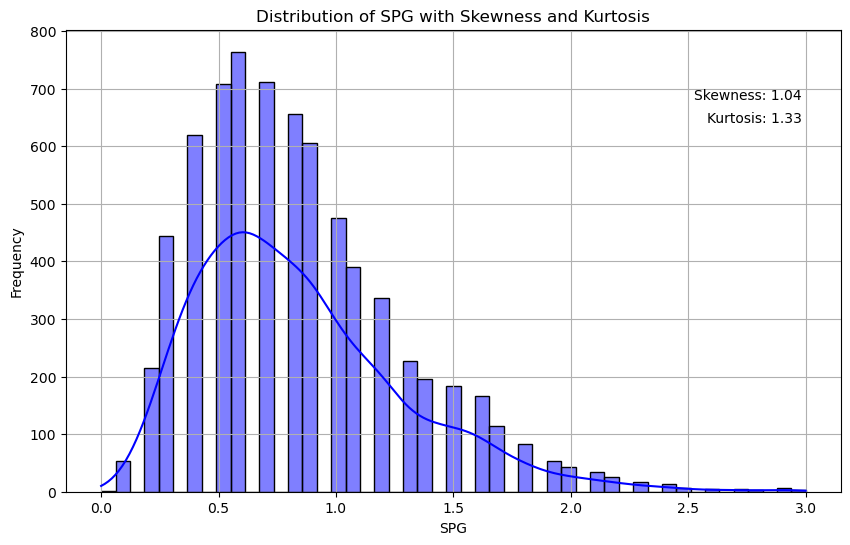

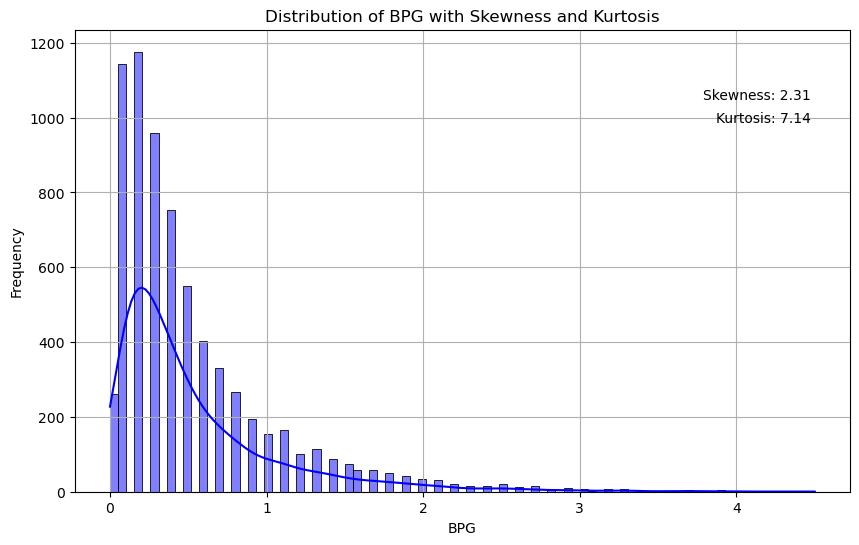

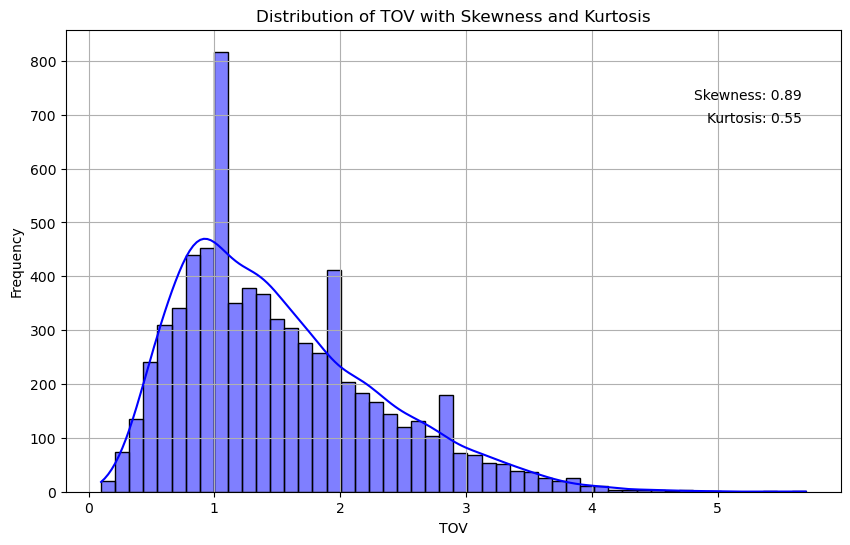

In [ ]:
columns = numeric_cols.columns

for col in columns:
  dist_plot(df, col)

# Position Breakdown

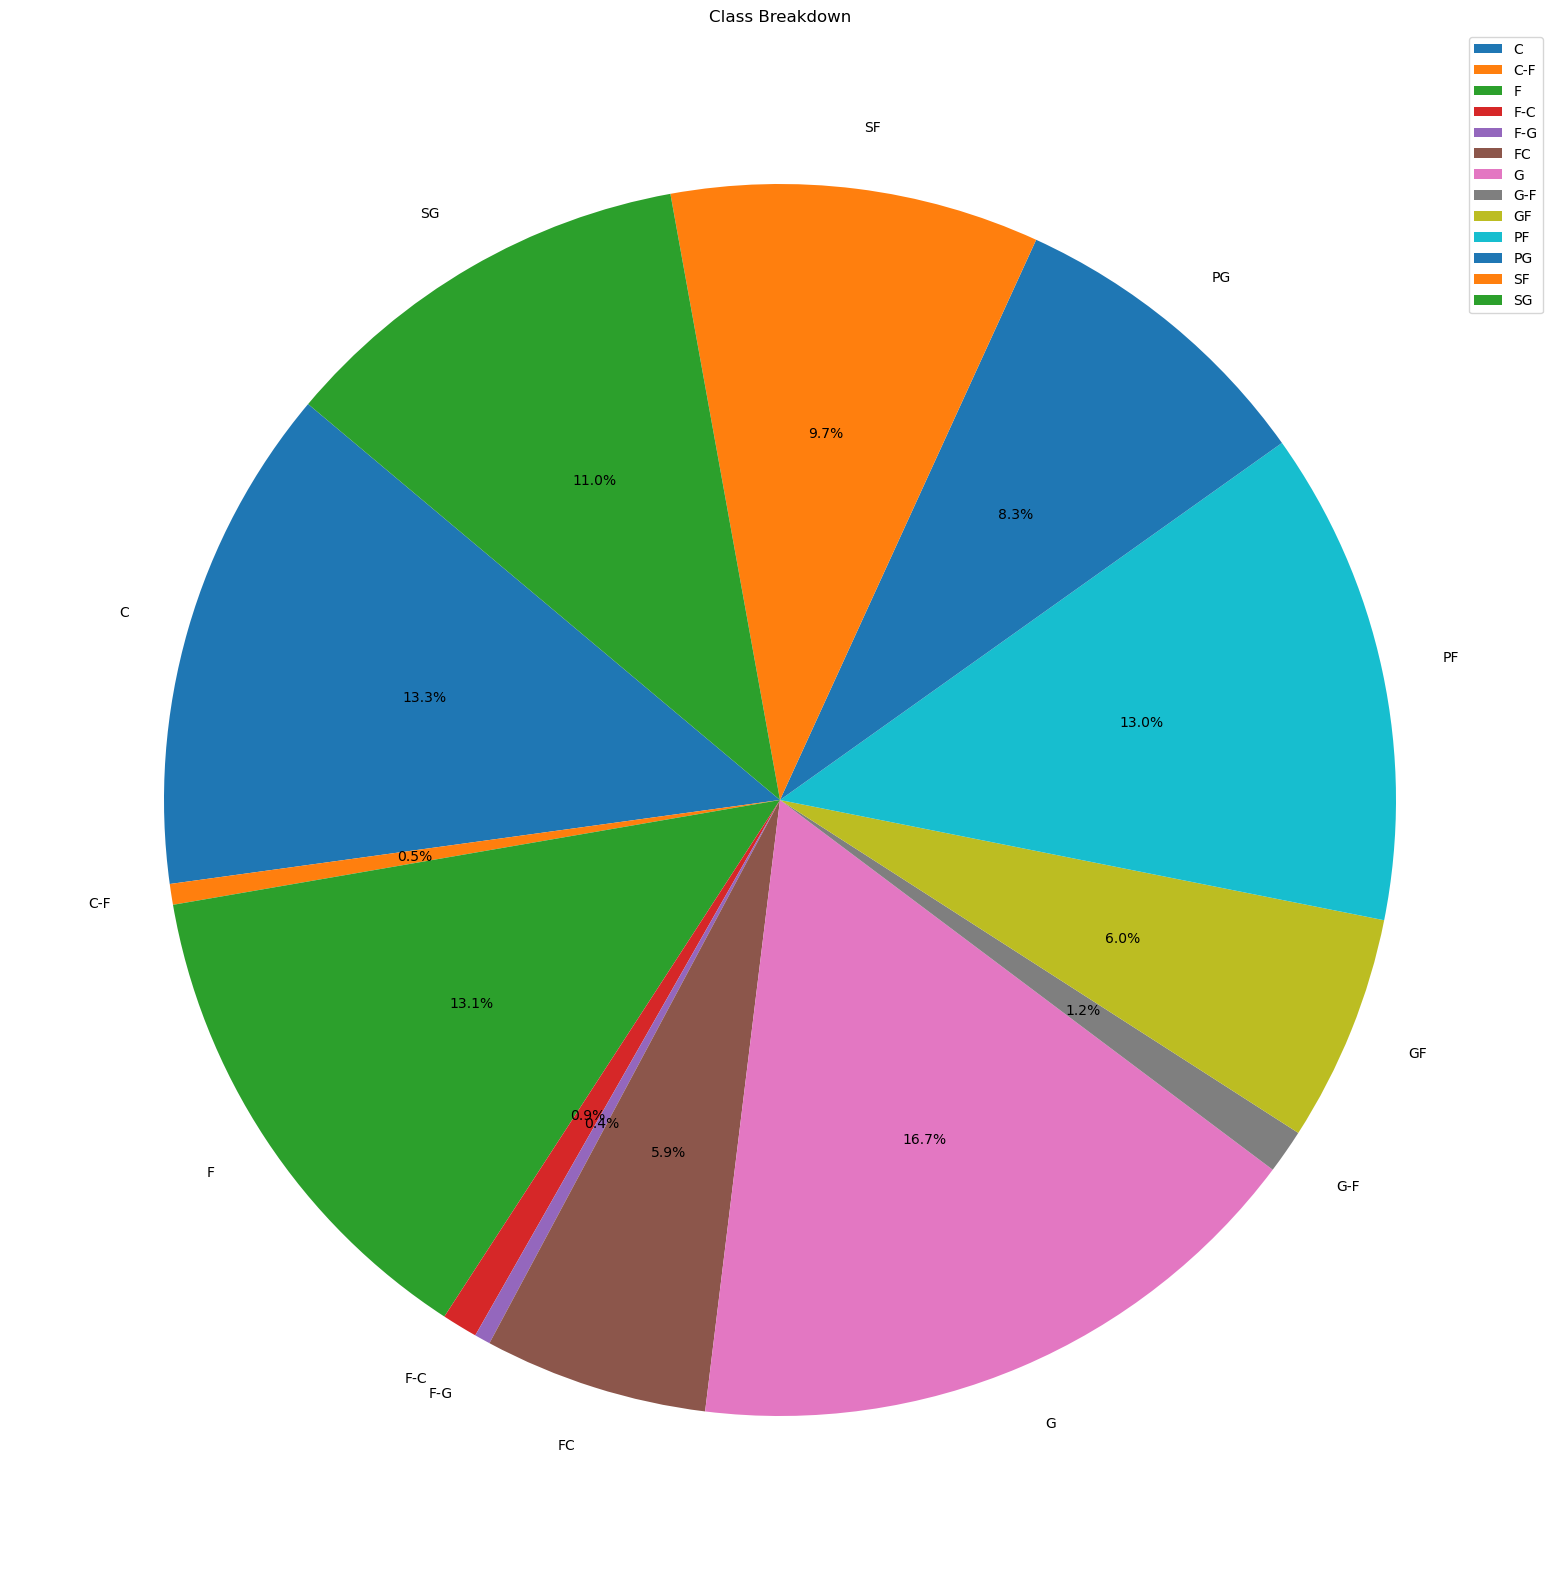

In [ ]:
class_imbalance(df["pos"])

In [ ]:
df["season"] = df["season"].apply(lambda x: int(x.split("-")[0]))

In [ ]:
new_df = df[(df["season"] >=2016) & (df["season"] <=2024) ]

In [ ]:
new_df["draft-status"] = new_df["draft-status"].apply(lambda x: x.split(" ")[-1])

/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_83302/1355807435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["draft-status"] = new_df["draft-status"].apply(lambda x: x.split(" ")[-1])


In [ ]:
new_df.drop(["Name", "Team", "nationality", "college-team", ""])

KeyError: "['Name', 'Team', 'nationality', 'college-team', ''] not found in axis"

In [ ]:
df

pos  height  weight  age           nationality    college-team  \
0     SG     6.6     215   27         United States  North Carolina   
1     PF     6.9     265   26         United States  Louisiana Tech   
2     SF     6.7     205   33         United States       Tennessee   
3     PF     6.6     252   27         United States          Auburn   
4      C     7.0     240   27  United StatesJamaica      Georgetown   
...   ..     ...     ...  ...                   ...             ...   
7159  PF     6.7     210   24                Canada        Syracuse   
7160   G     6.0     185   26         United States             USC   
7161  PF     6.1     240   31                Canada        Stanford   
7162  PF     6.9     240   22         United States         Arizona   
7163  PG     6.7     195   20         United States         Arizona   

                   draft-status     salary               Name Team  ...   FTA  \
0             1984 Rnd 1 Pick 3  2500000.0     Michael Jordan  CHI  ...   8.2   
1            1985 Rnd 1 Pick 13  2260000.0        Karl Malone  UTA  ...  10.8   
2             1977 Rnd 1 Pick 7  1600000.0       Bernard King  WAS  ...   7.6   
3             1984 Rnd 1 Pick 5  2900000.0    Charles Barkley  PHI  ...   9.8   
4             1985 Rnd 1 Pick 1  4250000.0      Patrick Ewing  NYK  ...   7.7   
...                         ...        ...                ...  ...  ...   ...   
7159  2019 NBA Draft, Undrafted  2165000.0     Oshae Brissett  BOS  ...   1.5   
7160  2018 NBA Draft, Undrafted  2420000.0  Jordan McLaughlin  MIN  ...   0.3   
7161         2014 Rnd 2 Pick 15  4000000.0      Dwight Powell  DAL  ...   1.4   
7162         2020 Rnd 1 Pick 22  4306281.0         Zeke Nnaji  DEN  ...   1.1   
7163         2022 Rnd 1 Pick 18  3350760.0        Dalen Terry  CHI  ...   0.7   

        FT%  ORB  DRB   RPG  APG  SPG  BPG  TOV  season  
0     0.851  1.4  4.6   6.0  5.5  2.7  1.0  2.5    1990  
1     0.770  2.9  8.9  11.8  3.3  1.1  1.0  3.0    1990  
2     0.790  1.8  3.2   5.0  4.6  0.9  0.3  4.0    1990  
3     0.722  3.9  6.3  10.1  4.2  1.6  0.5  3.1    1990  
4     0.745  2.4  8.8  11.2  3.0  1.0  3.2  3.6    1990  
...     ...  ...  ...   ...  ...  ...  ...  ...     ...  
7159  0.602  1.1  1.8   2.9  0.8  0.3  0.1  0.4    2023  
7160  0.722  0.3  1.0   1.3  2.0  0.6  0.1  0.3    2023  
7161  0.708  1.5  1.9   3.4  1.3  0.4  0.3  0.5    2023  
7162  0.677  1.1  1.1   2.2  0.6  0.3  0.7  0.5    2023  
7163  0.581  0.5  1.4   1.9  1.4  0.5  0.3  0.5    2023  

[7164 rows x 30 columns]